# Dataset generation with webcam

In [1]:


"""import cv2

cap = cv2.VideoCapture(0)

count1 = 100
count2 = 100
count3 = 100
count4 = 100
while(True):
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)


    if(cv2.waitKey(1) & 0xFF == ord('a')):
        count1 += 1
        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('b')):
        count2 += 1
        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('c')):
        count3 += 1
        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('d')):
        count4 += 1
        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        cap.release()
        cv2.destroyAllWindows()
        break
"""

'import cv2\n\ncap = cv2.VideoCapture(0)\n\ncount1 = 100\ncount2 = 100\ncount3 = 100\ncount4 = 100\nwhile(True):\n    ret, frame = cap.read()\n    cv2.imshow("Live Video", frame)\n\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'a\')):\n        count1 += 1\n        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'b\')):\n        count2 += 1\n        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'c\')):\n        count3 += 1\n        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'d\')):\n        count4 += 1\n        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)\n\n    if(cv2.waitKey(1) & 0xFF == ord(\'q\')):\n        cap.release()\n        cv2.destroyAllWindows()\n        break\n'

# Save Files in CSV

In [ ]:
import os
import csv
from PIL import Image
import pillow_heif

# Ensure pillow-heif is installed
# pip install pillow pillow-heif

# Base directory where the dataset is stored
base_dir = "dataset"
# Output CSV file
output_csv = "images.csv"

def convert_heic_to_jpg(file_path):
    """
    Converts a HEIC image to JPG, replaces the original file, and returns the new file path.
    """
    heif_file = pillow_heif.read_heif(file_path)
    image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw")

    # Replace the original file by saving as JPG
    new_file_path = os.path.splitext(file_path)[0] + ".jpg"
    image.save(new_file_path, "JPEG")

    # Delete the original HEIC file
    os.remove(file_path)

    return new_file_path

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the headers
    writer.writerow(["Path", "Label"])

    # Walk through the dataset directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)

        # Ensure it's a folder
        if os.path.isdir(folder_path):
            # Assign labels based on folder name
            label = folder_name
            if folder_name == "gesture_1":
                label = "scissor"
            elif folder_name == "gesture_2":
                label = "rock"
            elif folder_name == "gesture_3":
                label = "paper"
            elif folder_name == "gesture_4":
                label = "nogesture"

            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Convert HEIC to JPG and replace the file
                if file_name.lower().endswith(".heic"):
                    file_path = convert_heic_to_jpg(file_path)
                    writer.writerow([file_path, label])
                # Ensure it's an image file
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Write the relative path and label to the CSV
                    writer.writerow([file_path, label])

print(f"Images and labels have been saved to {output_csv}")


Images and labels have been saved to images.csv


# Creating Custom Dataset + Data augmentation

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [4]:
import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Check if CUDA is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [5]:

# Function to show images
def imshow(img):
    if isinstance(img, torch.Tensor):
        img = img.numpy()

    img = img / 255.0  # Normalize if the pixel values are in range [0, 255]
    npimg = np.squeeze(img)

    if len(npimg.shape) == 2:  # Grayscale image
        plt.imshow(npimg, cmap='gray')
    elif len(npimg.shape) == 3 and npimg.shape[0] == 3:  # RGB image
        npimg = np.transpose(npimg, (1, 2, 0))  # (C, H, W) -> (H, W, C)
        plt.imshow(npimg)
    else:
        raise ValueError(f"Unexpected image shape: {npimg.shape}")

    plt.axis('off')
    plt.show()

In [6]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['scissor', 'rock', 'paper', 'nogesture'])}
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        
        image = Image.open(img_path)
        image = image.convert("RGB")
        
        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
import cv2
import numpy as np
import random

class CustomTransform:
    def __init__(self):
        self.counter_rotation = 0
        self.counter_flipping = 0
        self.counter_blurring = 0
        self.counter_sharpening = 0
        self.counter_noise = 0
        self.counter_scale = 0

    def random_rotation(self, image):
        """Rotate the image by a random angle (90, 180, or 270 degrees)."""
        _, rows, cols = image.shape
        angle = random.choice([90, 180, 270])  # Randomly choose an angle
        M = cv2.getRotationMatrix2D((cols / 2.0, rows / 2.0), angle, 1)
        rotated = cv2.warpAffine(image.transpose(1, 2, 0), M, (cols, rows))  # Convert from (C, H, W) to (H, W, C)
        rotated = rotated.transpose(2, 0, 1)  # Convert back to (C, H, W)

        rotated = np.clip(rotated,0,1)

        self.counter_rotation += 1
        return rotated

    def random_flipping(self, image):
        """
        Flip the image randomly.
        Input: PyTorch-style tensor (C, H, W) -> (3, 128, 128)
        Output: Flipped image in the same format (C, H, W)
        """
        # Ensure the input is a NumPy array (PyTorch tensors are commonly converted)
        if not isinstance(image, np.ndarray):
            raise TypeError("Input image must be a NumPy array.")

        # Ensure the shape is (C, H, W)
        if image.shape[0] != 3:
            raise ValueError(f"Expected input shape (3, H, W), but got {image.shape}.")

        # Randomly choose a flip mode: -1 (both axes), 0 (vertical), or 1 (horizontal)
        flip_code = random.choice([-1, 0, 1])

        # Perform flipping based on flip_code
        if flip_code == -1:  # Flip both vertically and horizontally
            flipped = image[:, ::-1, ::-1].copy()
        elif flip_code == 0:  # Flip vertically
            flipped = image[:, ::-1, :].copy()
        elif flip_code == 1:  # Flip horizontally
            flipped = image[:, :, ::-1].copy()
        else:
            raise ValueError("Invalid flip_code.")
        flipped = np.clip(flipped,0,1)

        self.counter_flipping += 1
        return flipped


    def random_blurring(self, image):
        """Apply random Gaussian blur."""
        kernel_size = random.choice([3, 5, 7])  # Use smaller kernel sizes
        blurred = cv2.GaussianBlur(image.transpose(1, 2, 0), (kernel_size, kernel_size), 0)  # Convert to (H, W, C)

        blurred = blurred.transpose(2, 0, 1)  # Convert back to (C, H, W)
        
        blurred = np.clip(blurred,0,1)

        self.counter_blurring += 1
        return blurred

    def random_sharpening(self, image):
        """Apply a sharpening kernel only on the luminance channel (L) to avoid excessive color distortion."""
        
        image_lab = cv2.cvtColor(image.transpose(1, 2, 0), cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(image_lab)
        
        # Sharpen the luminance channel (L) using a 3x3 kernel
        kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]])
        sharpened_L = cv2.filter2D(L, -1, kernel)
        image_lab_sharpened = cv2.merge([sharpened_L, A, B])      
        sharpened_rgb = cv2.cvtColor(image_lab_sharpened, cv2.COLOR_LAB2RGB)
        sharpened_rgb = sharpened_rgb.transpose(2, 0, 1)
        sharpened_rgb = np.clip(sharpened_rgb, 0, 1)
        
        self.counter_sharpening += 1
        return sharpened_rgb

    def add_random_noise(self, image):
        """Add random Gaussian noise."""
        # Ensure the image is in float32 format and normalized
        image = (image - image.min()) / (image.max() - image.min())
        _, row, col = image.shape

        # Gaussian noise parameters
        mean = 0
        var = random.uniform(0.001, 0.009)  # Larger variance for visible noise
        sigma = var ** 0.5

        # Generate Gaussian noise of shape (C, H, W), matching the image's shape
        gauss = np.random.normal(mean, sigma, (3, row, col)).astype(np.float32)  # (C, H, W) for RGB image

        # Add the Gaussian noise to the image
        noisy = image + gauss  # Add noise directly to each channel

        # Clip the values to stay within [0, 1], then scale back to [0, 255]
        noisy = np.clip(noisy, 0, 1)

        self.counter_noise += 1
        return noisy



    def random_scaling(self, image):
        """Apply random scaling to the image for a zoom effect. """
        scaling_zoom_factor = random.uniform(1.1, 1.6)
        
        zoomed = cv2.resize(image.transpose(1, 2, 0), None, fx=scaling_zoom_factor, fy=scaling_zoom_factor, interpolation=cv2.INTER_LINEAR)

        center_x, center_y = zoomed.shape[1] // 2, zoomed.shape[0] // 2
        crop_size = 128

        random_scale = zoomed[center_y - crop_size // 2: center_y + crop_size // 2,
                                center_x - crop_size // 2: center_x + crop_size // 2]

        random_scale = random_scale.transpose(2, 0, 1)
        random_scale = np.clip(random_scale, 0, 1)

        self.counter_scale += 1
        return random_scale


    def normalize_image(self, image):
        """Normalize the image to [0, 1] range for CNN input."""
        image = image.astype(np.float32) / 255.0
        return image
    
    def __call__(self, image):
        """Apply a random combination of augmentations."""
        augmentations = [
            self.random_rotation,
            self.random_flipping,
            self.random_blurring,
            self.random_sharpening,
            self.add_random_noise,
        ]
        random.shuffle(augmentations)
        
        # Apply the first transformation from the shuffled list
        transformed = augmentations[0](image)
        # Apply scaling to ensure the final output is standardized
        scaled_transformed = self.random_scaling(transformed)


        return (
            transformed,
            scaled_transformed,
            self.counter_rotation,
            self.counter_flipping,
            self.counter_blurring,
            self.counter_sharpening,
            self.counter_noise,
            self.counter_scale,
        )



In [8]:
import os
import numpy as np
import torch
from PIL import Image
import random
import shutil

# Augment Dataset with Labels and Save Images
def augment_and_add_to_dataset(dataset, transform, num_augmentations=1, save_dir='augmented_dataset'):
    """
    Augment the dataset by applying transformations to each image
    and appending the augmented images with the same labels to the dataset.
    Saves the augmented images in class-specific directories.

    Args:
        dataset: The original dataset (CustomImageDataset or similar).
        transform: The transformation class with custom augmentation functions.
        num_augmentations: Number of augmented versions to create per image.
        save_dir: Root directory where augmented images will be saved.

    Returns:
        Augmented dataset (list of tuples with image tensor and label).
    """
    counter_rotation = 0
    counter_flipping = 0
    counter_blurring = 0
    counter_sharpening = 0
    counter_noise = 0
    counter_scaling = 0

    """   # Clear the directory if it exists
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)  # Delete everything inside the folder
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the base directory for augmented dataset
    """
    augmented_data = []

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        
        # Convert tensor back to numpy for transformation
        original_image = image.squeeze(0).numpy()
   

        # Create class-specific directory if it doesn't exist
        class_dir = os.path.join(save_dir, f'class_{label}')
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        augmented_data.append((image, label))
        
        # Create augmented versions and save them
        for i in range(num_augmentations):
            augmented_image, scaled, counter_rotation,counter_flipping, counter_blurring, counter_sharpening, counter_noise, counter_scaling = transform(original_image)
            augmented_image_tensor = torch.tensor(augmented_image)
            scaled_tensor = torch.tensor(scaled)
            # Save augmented image
            #save_image(augmented_image, class_dir,num_augmentations, f'aug_{i + 1}_{label}')
            #save_image(scaled, class_dir,num_augmentations, f'scal_{i + 1}_{label}')

            augmented_data.append((augmented_image_tensor, label))
            augmented_data.append((scaled_tensor, label))


     # Apply only the first transformation from the shuffled list
    print("Counter rotation: ", counter_rotation)
    print("Counter flipping: ", counter_flipping)
    print("Counter blurring: ", counter_blurring)
    print("Counter sharpening: ", counter_sharpening)
    print("Counter noise: ", counter_noise)
    print("Counter scaling: ", counter_scaling)
    return augmented_data


def save_image(image, class_dir, num_augmentations, suffix):
    """
    Save the image to the specified directory with the given suffix.
    """

    # If the image has shape (channels, height, width), transpose to (height, width, channels)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0)) # (C, H, W) -> (H, W, C)
    
    # Convert to uint8 if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image)

    # Create a unique filename for each image
    filename = f"{suffix}_{random.randint(0, 10000)}.jpg"  # Adding randomness to avoid overwriting

    # Save the image in the class directory
    pil_image.save(os.path.join(class_dir, filename))





In [9]:
seed = 42
generator = torch.Generator().manual_seed(seed)

BATCH_SIZE = 64

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

classes = ('scissor', 'rock', 'paper', 'nogesture')

transform = transforms.Compose([
    transforms.Resize((128, 128)),        # Resize image to 128x128
    transforms.ToTensor()                # Convert image to PyTorch tensor (C, H, W)
    ])

# Instantiate custom transformation
custom_transform_100 = CustomTransform()
custom_transform_200 = CustomTransform()
custom_transform_300 = CustomTransform()

# Create original dataset
original_dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)
print(f"Original dataset size: {len(original_dataset)}")
# Split dataset into 80% train and 20% test
train_size_original = int(0.8 * len(original_dataset))
test_size_original = len(original_dataset) - train_size_original
train_set_original, test_set_original = random_split(original_dataset, [train_size_original, test_size_original],generator=generator)
print(f"Trainset original size: {len(train_set_original)}")
print(f"Testset original size: {len(test_set_original)}")
# Create DataLoaders
train_loader_original = DataLoader(train_set_original, batch_size=BATCH_SIZE, shuffle=True)
test_loader_original = DataLoader(test_set_original, batch_size=BATCH_SIZE, shuffle=False)


# Augment the dataset by 100 images per class
num_augmentations_1 = 2  # Number of augmented versions per original image
augmented_dataset_1 = augment_and_add_to_dataset(original_dataset, custom_transform_100, num_augmentations_1, save_dir='augmented_rps_100')
print(f"Augmented dataset size: {len(augmented_dataset_1)}")
# Split dataset into 80% train and 20% 
train_size_augmented_1 = int(0.8 * len(augmented_dataset_1))
test_size_augmented_1 = len(augmented_dataset_1) - train_size_augmented_1
train_set_100, test_set_100 = random_split(augmented_dataset_1, [train_size_augmented_1, test_size_augmented_1],generator=generator)
print(f"Trainset augmented_1 size: {len(train_set_100)}")
print(f"Testset augmented_1 size: {len(test_set_100)}")
# Create DataLoaders
train_loader_augmented_1 = DataLoader(train_set_100, batch_size=BATCH_SIZE, shuffle=True)
test_loader_augmented_1 = DataLoader(test_set_100, batch_size=BATCH_SIZE, shuffle=False)



# Augment the dataset by 200 images per class
num_augmentations_2 = 4  # Number of augmented versions per original image
augmented_dataset_2 = augment_and_add_to_dataset(original_dataset, custom_transform_200, num_augmentations_2, save_dir='augmented_rps_200')
print(f"Augmented dataset size: {len(augmented_dataset_2)}")
# Split dataset into 80% train and 20% test
train_size_augmented_2 = int(0.8 * len(augmented_dataset_2))
test_size_augmented_2 = len(augmented_dataset_2) - train_size_augmented_2
train_set_200, test_set_200 = random_split(augmented_dataset_2, [train_size_augmented_2, test_size_augmented_2],generator=generator)
print(f"Trainset augmented_2 size: {len(train_set_200)}")
print(f"Testset augmented_2 size: {len(test_set_200)}")
# Create DataLoaders
train_loader_augmented_2 = DataLoader(train_set_200, batch_size=BATCH_SIZE, shuffle=True)
test_loader_augmented_2 = DataLoader(test_set_200, batch_size=BATCH_SIZE, shuffle=False)


# Augment the dataset by 300 images per class
num_augmentations_3 = 6  # Number of augmented versions per original image
augmented_dataset_3 = augment_and_add_to_dataset(original_dataset, custom_transform_300, num_augmentations_3, save_dir='augmented_rps_300')
print(f"Augmented dataset size: {len(augmented_dataset_3)}")
# Split dataset into 80% train and 20% test
train_size_augmented_3 = int(0.8 * len(augmented_dataset_3))
test_size_augmented_3 = len(augmented_dataset_3) - train_size_augmented_3
train_set_300, test_set_300 = random_split(augmented_dataset_3, [train_size_augmented_3, test_size_augmented_3],generator=generator)
print(f"Trainset augmented_3 size: {len(train_set_300)}")
print(f"Testset augmented_3 size: {len(test_set_300)}")
# Create DataLoaders
train_loader_augmented_3 = DataLoader(train_set_300, batch_size=BATCH_SIZE, shuffle=True)
test_loader_augmented_3 = DataLoader(test_set_300, batch_size=BATCH_SIZE, shuffle=False)



Current directory: /home/andiv/OneDrive/UIBK/Semester5/VisualComputing/Visual-Project
Original dataset size: 800
Trainset original size: 640
Testset original size: 160
Counter rotation:  323
Counter flipping:  278
Counter blurring:  347
Counter sharpening:  327
Counter noise:  325
Counter scaling:  1600
Augmented dataset size: 4000
Trainset augmented_1 size: 3200
Testset augmented_1 size: 800
Counter rotation:  633
Counter flipping:  592
Counter blurring:  636
Counter sharpening:  675
Counter noise:  664
Counter scaling:  3200
Augmented dataset size: 7200
Trainset augmented_2 size: 5760
Testset augmented_2 size: 1440
Counter rotation:  956
Counter flipping:  979
Counter blurring:  952
Counter sharpening:  970
Counter noise:  943
Counter scaling:  4800
Augmented dataset size: 10400
Trainset augmented_3 size: 8320
Testset augmented_3 size: 2080


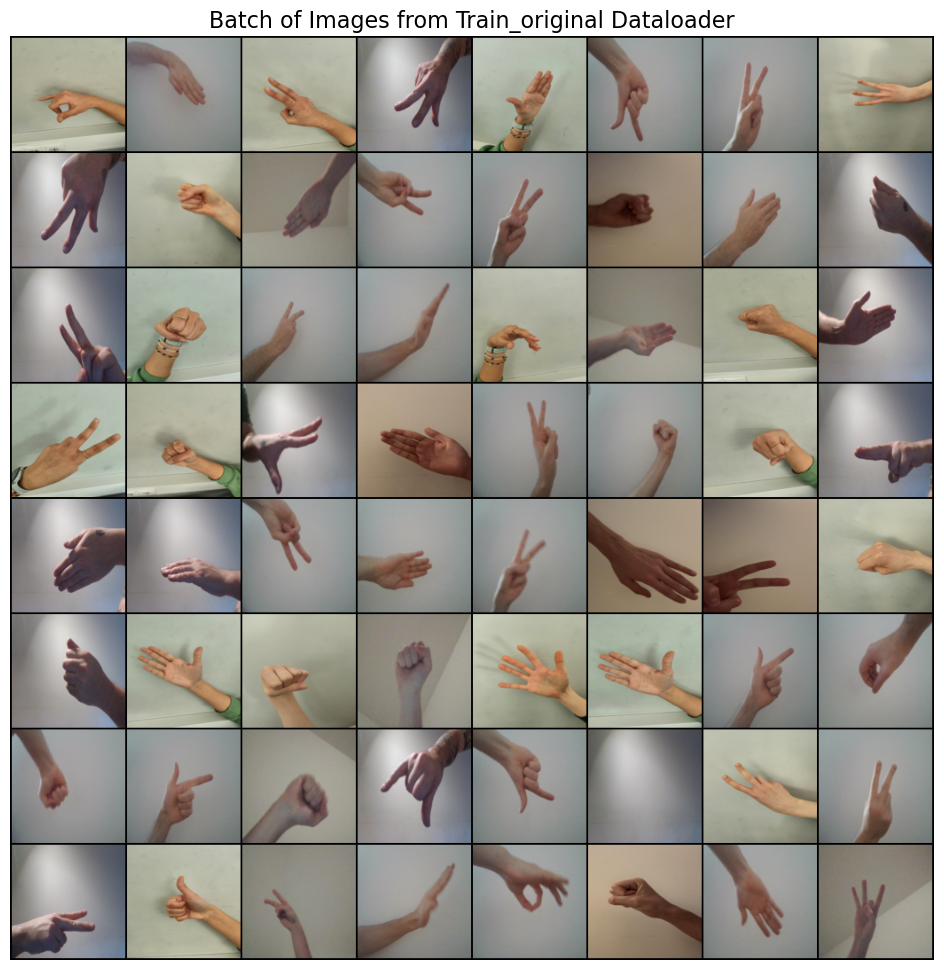

In [10]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming train_loader_original is already defined
dataiter = iter(train_loader_original)

# Get the next batch
images, labels = next(dataiter)

# Move images to device (e.g., GPU)
images = images.to(device)

# Create a grid for the whole batch
# Customize the number of columns (e.g., 8) using `nrow`
grid = make_grid(images.cpu(), nrow=8, padding=2, normalize=True)

# Plot the image using matplotlib
plt.figure(figsize=(12, 12))  # Adjust the figure size
plt.imshow(grid.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
plt.axis('off')  # Turn off axis labels
plt.title("Batch of Images from Train_original Dataloader", fontsize=16)  # Add a title
plt.show()


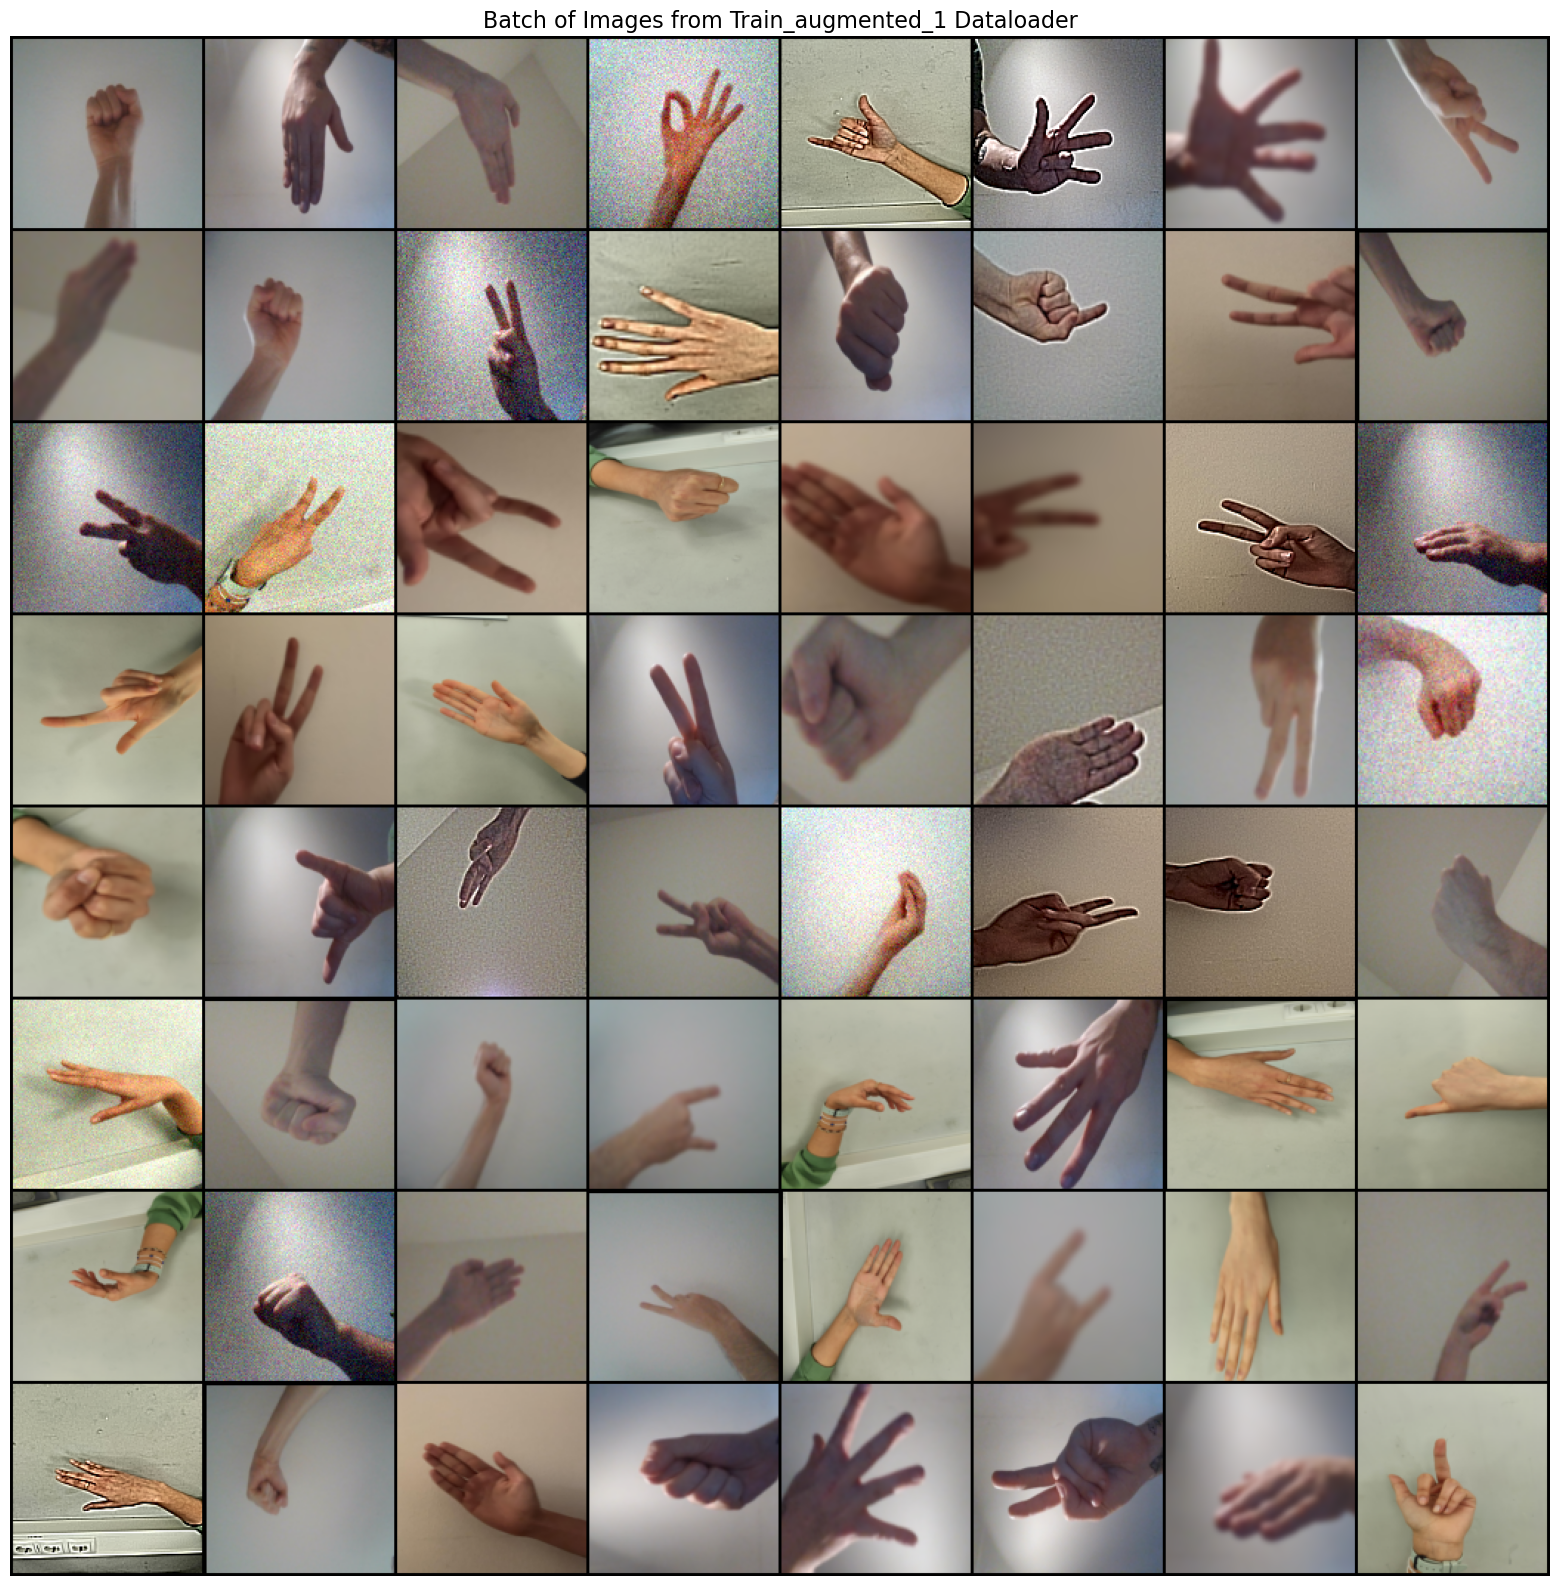

In [11]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming train_loader_original is already defined
dataiter = iter(train_loader_augmented_1)

# Get the next batch
images, labels = next(dataiter)

# Move images to device (e.g., GPU)
images = images.to(device)


# Create a grid for the whole batch
# Customize the number of columns (e.g., 8) using `nrow`
grid = make_grid(images.cpu(), nrow=8, padding=2, normalize=True)


# Plot the image using matplotlib
plt.figure(figsize=(20, 20))  # Adjust the figure size
plt.imshow(grid.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
plt.axis('off')  # Turn off axis labels
plt.title("Batch of Images from Train_augmented_1 Dataloader", fontsize=16)  # Add a title
plt.show()


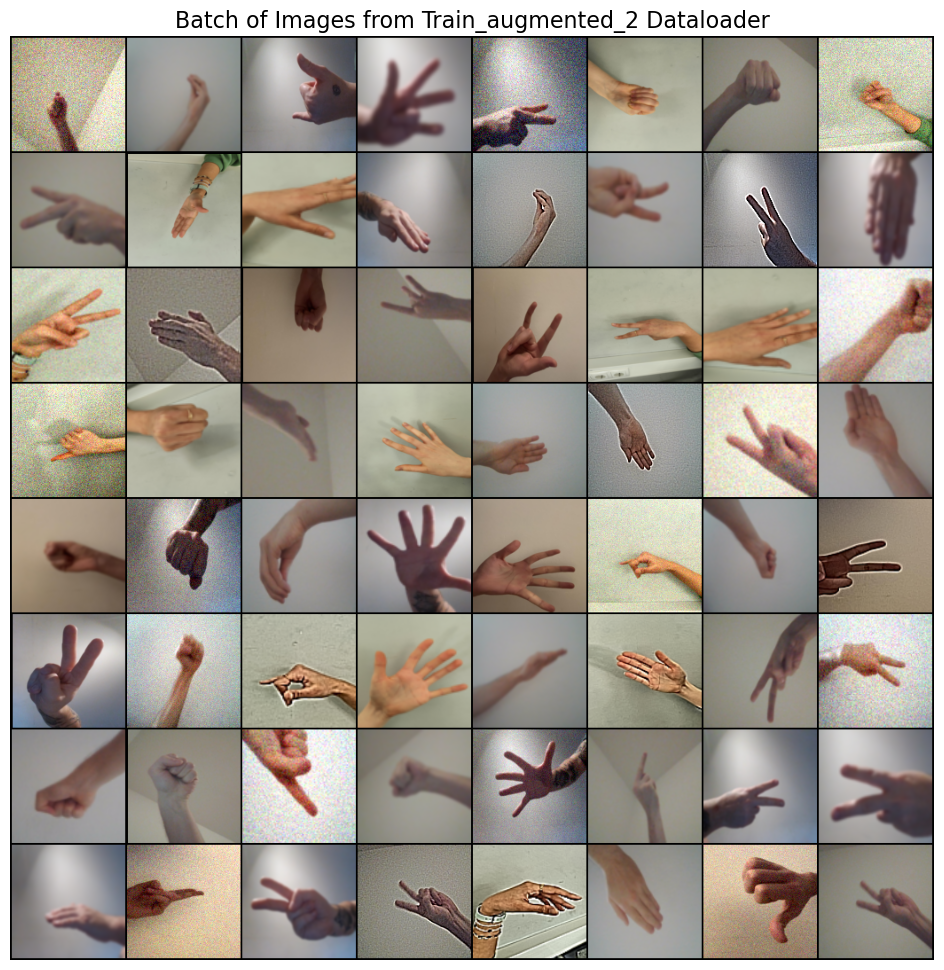

In [12]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming train_loader_original is already defined
dataiter = iter(train_loader_augmented_2)

# Get the next batch
images, labels = next(dataiter)

# Move images to device (e.g., GPU)
images = images.to(device)

# Create a grid for the whole batch
# Customize the number of columns (e.g., 8) using `nrow`
grid = make_grid(images.cpu(), nrow=8, padding=2, normalize=True)

# Plot the image using matplotlib
plt.figure(figsize=(12, 12))  # Adjust the figure size
plt.imshow(grid.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
plt.axis('off')  # Turn off axis labels
plt.title("Batch of Images from Train_augmented_2 Dataloader", fontsize=16)  # Add a title
plt.show()


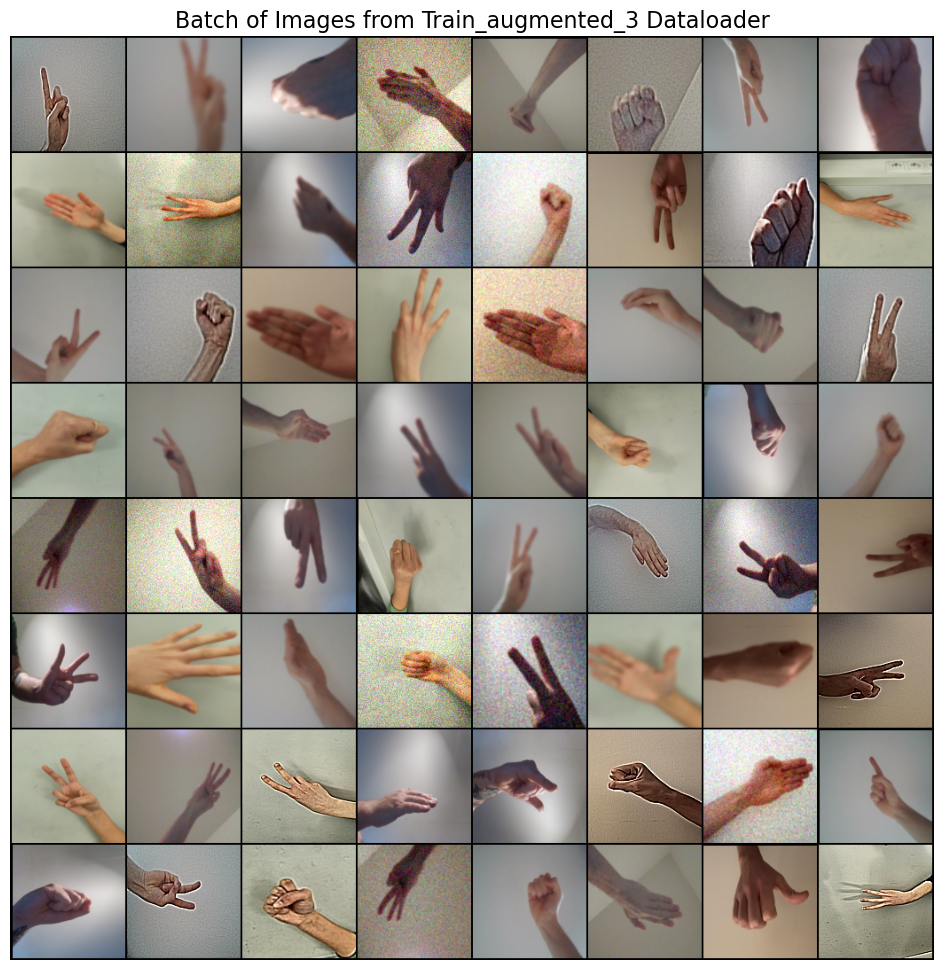

In [13]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming train_loader_original is already defined
dataiter = iter(train_loader_augmented_3)

# Get the next batch
images, labels = next(dataiter)

# Move images to device (e.g., GPU)
images = images.to(device)

# Create a grid for the whole batch
# Customize the number of columns (e.g., 8) using `nrow`
grid = make_grid(images.cpu(), nrow=8, padding=2, normalize=True)

# Plot the image using matplotlib
plt.figure(figsize=(12, 12))  # Adjust the figure size
plt.imshow(grid.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
plt.axis('off')  # Turn off axis labels
plt.title("Batch of Images from Train_augmented_3 Dataloader", fontsize=16)  # Add a title
plt.show()


In [14]:
# Assuming train_loader_augmented_1 is already defined
dataiter = iter(train_loader_augmented_3)

# Get the next batch
images, labels = next(dataiter)

# Move images to device (e.g., GPU)
images = images.to(device)

# Create a grid for the whole batch
# Customize the number of columns (e.g., 8) using `nrow`
grid = make_grid(images.cpu(), nrow=8, padding=2, normalize=True)

# Convert grid to a PIL image for display
img = ToPILImage()(grid)

# Display the image
img.show()

In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Function to show images in the dataset
def show_images(dataset):
    # Assuming the dataset is a list or array of tensors
    for i, img_tensor in enumerate(dataset):
        image, target = img_tensor
        # Convert tensor to numpy array (for display)
        img = image.permute(1, 2, 0).numpy()  # Permuting to HWC format (Height, Width, Channels)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.show()


# CNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = ((input_size - kernel_size + 2*padding) / stride) + 1

#Since we have RGB images we have 3 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 128x128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 128x128 -> 64x64
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 64x64 -> 32x32
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32x32 -> 16x16
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 16x16 -> 8x8
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)  # Halves the spatial dimensions
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 128 * 8 * 8)  # Flatten
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [17]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 30
WEIGHT_DECAY = 1e-5  # Add weight decay regularization


# Check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

print(device)



model_original = Net()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion_original = nn.CrossEntropyLoss()
scheduler_original = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_original, mode='min', patience=3)

model_augmented_1 = Net()
optimizer_augmented_1 = torch.optim.Adam(model_augmented_1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion_augmented_1 = nn.CrossEntropyLoss()
scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_augmented_1, mode='min', patience=3)

model_augmented_2 = Net()
optimizer_augmented_2 = torch.optim.Adam(model_augmented_2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion_augmented_2 = nn.CrossEntropyLoss()
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_augmented_2, mode='min', patience=3)

model_augmented_3 = Net()
optimizer_augmented_3 = torch.optim.Adam(model_augmented_3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion_augmented_3 = nn.CrossEntropyLoss()
scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_augmented_3, mode='min', patience=3)


print(model_original)


Using device: cpu
cpu
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=T

/bin/eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [19]:
pip install torchsummary

from torchsummary import summary

summary(model_original, (3, 128, 128)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
       BatchNorm2d-5           [-1, 32, 64, 64]              64
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Linear-13                  [-1, 512]       4,194,816
          Dropout-14                  [

# Training

In [20]:
def imshow(img):
    print(img.shape)
    #img = img / 2 + 0.5  # Unnormalize (if normalized with mean=0.5, std=0.5)
    npimg = img.numpy()

    # Remove extra singleton dimensions (e.g., (1, 1, 32, 32) -> (1, 32, 32))
    npimg = np.squeeze(npimg)
    
    if len(npimg.shape) == 2:  # If the image is 2D (grayscale)
        plt.imshow(npimg, cmap='gray')
    elif len(npimg.shape) == 3 and npimg.shape[0] == 3:  # If the image has 3 channels (RGB)
        npimg = np.transpose(npimg, (1, 2, 0))  # Transpose to (H, W, 3) for RGB
            # Convert to uint8 if necessary
        if npimg.dtype != np.uint8:
            npimg = (npimg * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        print(npimg.shape)
        plt.imshow(npimg)
    else:
        raise ValueError("Unexpected image shape: {}".format(npimg.shape))

    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

In [21]:
def train(model, train_loader, optimizer, criterion, scheduler=None, n_epochs=None):
    model.train()
    losses = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Collect statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss_value

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, loss: {epoch_loss}")

        # Step the scheduler if provided
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # ReduceLROnPlateau expects validation loss or another metric
                scheduler.step(epoch_loss)
            else:
                scheduler.step()

    print('Finished Training')
    return losses


In [22]:
"""# Early stopping parameters
patience = 5 # Number of epochs to wait before stopping
min_delta = 0.01 # Minimum change in loss to qualify as an improvement

def train_early_stopping(model, train_loader, val_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    patience_counter = 0
    best_loss = float('inf')

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
        
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader)}")
        
        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # No gradients needed for validation
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)  # Average validation loss
        print(f"Epoch {epoch + 1}, Validation loss: {val_loss}")

        # Check for improvement
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Best validation loss: {best_loss}")
    print('Finished Training')
    return losses
"""

'# Early stopping parameters\npatience = 5 # Number of epochs to wait before stopping\nmin_delta = 0.01 # Minimum change in loss to qualify as an improvement\n\ndef train_early_stopping(model, train_loader, val_loader, optimizer, criterion, n_epochs=None):\n    model.train()\n    losses = []\n    patience_counter = 0\n    best_loss = float(\'inf\')\n\n    for epoch in range(n_epochs):  # loop over the dataset multiple times\n        running_loss = 0.0\n        for i, data in enumerate(train_loader, 0):\n            # Get the inputs; data is a list of [inputs, labels]\n            inputs, labels = data[0].to(device), data[1].to(device)\n        \n            # Zero the parameter gradients\n            optimizer.zero_grad()\n\n            # Forward + backward + optimize\n            outputs = model(inputs)\n            loss = criterion(outputs, labels)\n            loss.backward()\n            optimizer.step()\n\n            # Print statistics\n            loss_value = loss.item()\n     

Epoch 1, loss: 2.002855324745178
Epoch 2, loss: 1.433501958847046
Epoch 3, loss: 1.3694471716880798
Epoch 4, loss: 1.34857519865036
Epoch 5, loss: 1.3119258761405945
Epoch 6, loss: 1.2723967909812928
Epoch 7, loss: 1.2167067885398866
Epoch 8, loss: 1.1695107340812683
Epoch 9, loss: 1.1556567907333375
Epoch 10, loss: 1.0710714221000672
Epoch 11, loss: 0.9407169282436371
Epoch 12, loss: 0.9022471070289612
Epoch 13, loss: 0.9219265758991242
Epoch 14, loss: 0.8006914913654327
Epoch 15, loss: 0.7647267580032349
Epoch 16, loss: 0.7014687418937683
Epoch 17, loss: 0.675034973025322
Epoch 18, loss: 0.6185954749584198
Epoch 19, loss: 0.5591705590486526
Epoch 20, loss: 0.518133494257927
Epoch 21, loss: 0.45754915475845337
Epoch 22, loss: 0.4172866314649582
Epoch 23, loss: 0.37915937453508375
Epoch 24, loss: 0.3712301939725876
Epoch 25, loss: 0.3066971778869629
Epoch 26, loss: 0.273615263402462
Epoch 27, loss: 0.31254525631666186
Epoch 28, loss: 0.29772171676158904
Epoch 29, loss: 0.24437453448772

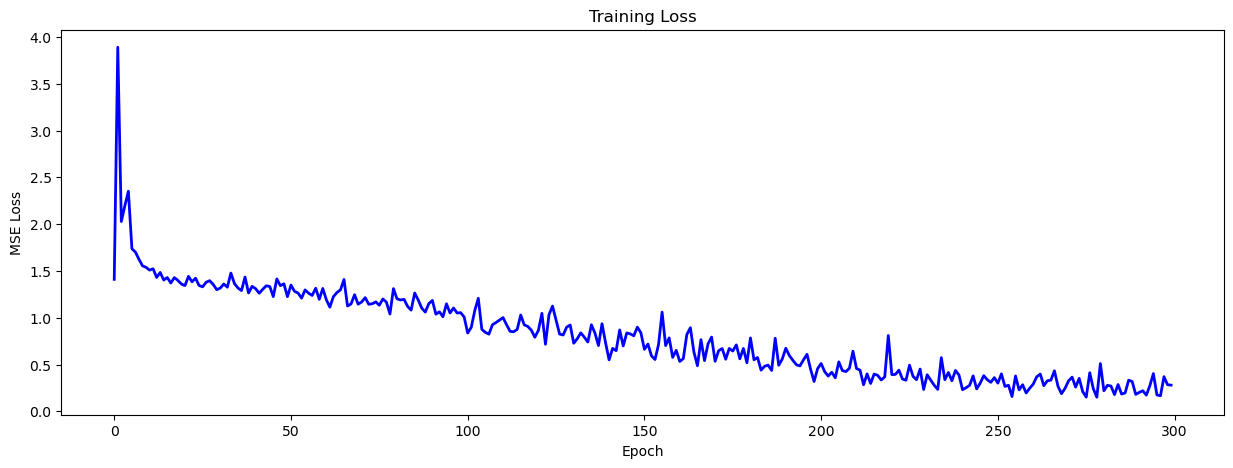

In [23]:

losses_original = train(model=model_original, train_loader=train_loader_original, optimizer=optimizer_original, criterion=criterion_original, n_epochs=EPOCHS)

#losses_original = train_early_stopping(model_original,train_loader=train_loader_original,val_loader=test_loader_original, optimizer=optimizer_original, criterion=criterion_original,n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_original, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_original.pth'
torch.save(model_original.state_dict(), PATH)

Epoch 1, loss: 1.5480909895896913
Epoch 2, loss: 1.3982915210723876
Epoch 3, loss: 1.3844236540794372
Epoch 4, loss: 1.3631567668914795
Epoch 5, loss: 1.3316187763214111
Epoch 6, loss: 1.30535089969635
Epoch 7, loss: 1.2844454884529113
Epoch 8, loss: 1.2321049499511718
Epoch 9, loss: 1.1580757761001588
Epoch 10, loss: 1.0540671288967132
Epoch 11, loss: 0.9739974617958069
Epoch 12, loss: 0.9374447286128997
Epoch 13, loss: 0.8454890275001525
Epoch 14, loss: 0.7917855322360993
Epoch 15, loss: 0.7371228605508804
Epoch 16, loss: 0.6748810786008835
Epoch 17, loss: 0.5762692040205002
Epoch 18, loss: 0.5399340689182281
Epoch 19, loss: 0.4827414393424988
Epoch 20, loss: 0.44348532021045683
Epoch 21, loss: 0.3870843756198883
Epoch 22, loss: 0.38990859806537626
Epoch 23, loss: 0.3560261505842209
Epoch 24, loss: 0.31219898879528046
Epoch 25, loss: 0.29190837681293486
Epoch 26, loss: 0.24248076274991034
Epoch 27, loss: 0.24297240436077117
Epoch 28, loss: 0.21800506755709648
Epoch 29, loss: 0.201229

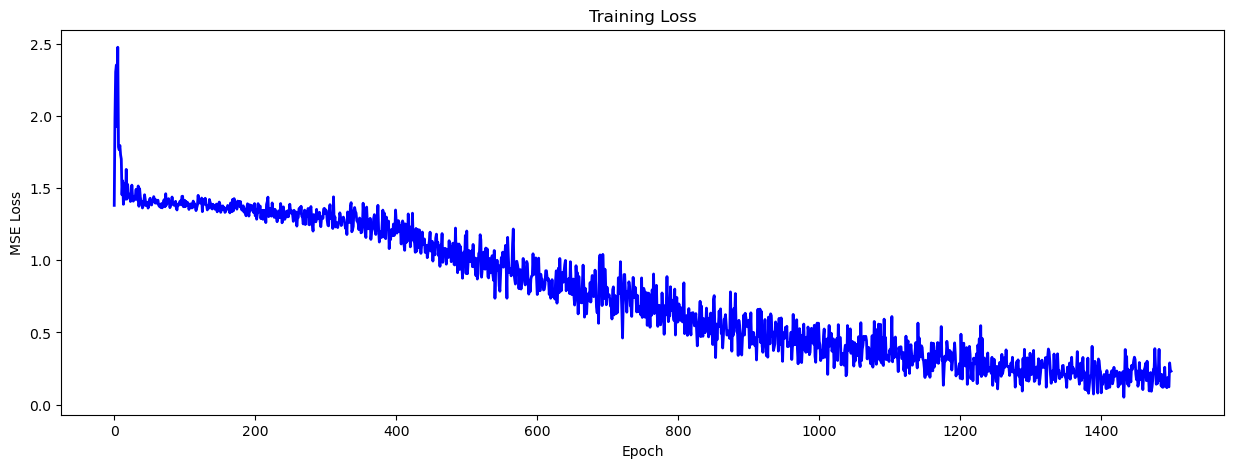

In [24]:

losses_100 = train(model=model_augmented_1, train_loader=train_loader_augmented_1, optimizer=optimizer_augmented_1, criterion=criterion_augmented_1, n_epochs=EPOCHS)

#losses_100 = train_early_stopping(model_augmented_1,train_loader=train_loader_augmented_1, val_loader=test_loader_augmented_1, optimizer=optimizer_augmented_1,criterion=criterion_augmented_1,n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_100, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_augmented_1.pth'
torch.save(model_augmented_1.state_dict(), PATH)

Epoch 1, loss: 1.4633726822005377
Epoch 2, loss: 1.3826814691225688
Epoch 3, loss: 1.354052291976081
Epoch 4, loss: 1.2835835721757678
Epoch 5, loss: 1.1621682816081578
Epoch 6, loss: 0.9873535878128475
Epoch 7, loss: 0.8472239083713955
Epoch 8, loss: 0.7155961930751801
Epoch 9, loss: 0.6062706106238895
Epoch 10, loss: 0.5205837150414785
Epoch 11, loss: 0.4596238411135144
Epoch 12, loss: 0.4068346035149362
Epoch 13, loss: 0.3629978969693184
Epoch 14, loss: 0.2993608930044704
Epoch 15, loss: 0.2846973232097096
Epoch 16, loss: 0.2509933935271369
Epoch 17, loss: 0.21015724614262582
Epoch 18, loss: 0.2065206175049146
Epoch 19, loss: 0.2018124150733153
Epoch 20, loss: 0.17353464687863987
Epoch 21, loss: 0.16511253714561464
Epoch 22, loss: 0.1432220696989033
Epoch 23, loss: 0.12731165190537772
Epoch 24, loss: 0.12866161237988208
Epoch 25, loss: 0.12984184568954837
Epoch 26, loss: 0.11498256184988552
Epoch 27, loss: 0.09884207393560145
Epoch 28, loss: 0.08115033752595385
Epoch 29, loss: 0.102

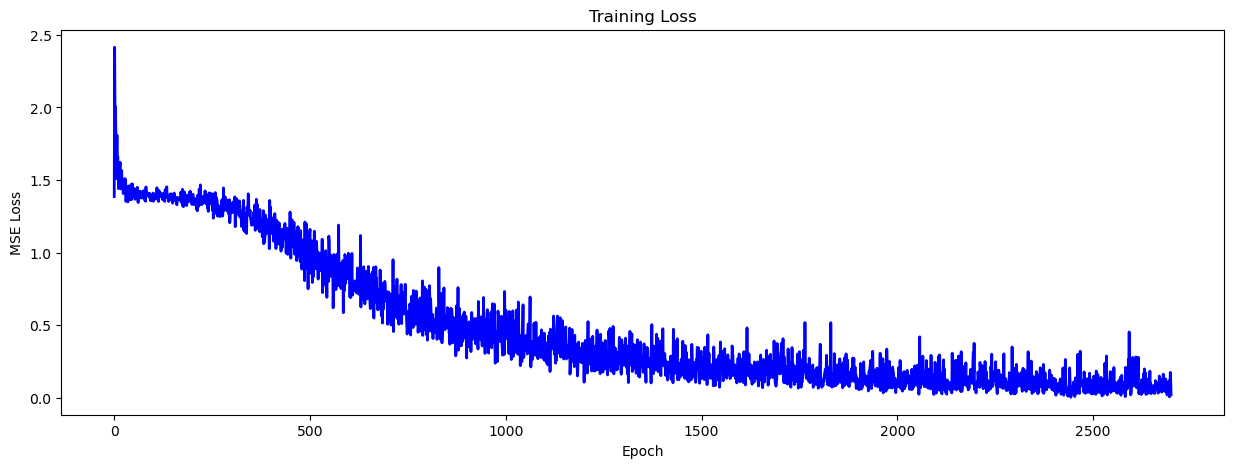

In [25]:
losses_200 = train(model=model_augmented_2, train_loader=train_loader_augmented_2, optimizer=optimizer_augmented_2, criterion=criterion_augmented_2, n_epochs=EPOCHS)

#losses_200 = train_early_stopping(model=model_augmented_2, train_loader=train_loader_augmented_2,val_loader=test_loader_augmented_2, optimizer=optimizer_augmented_2, criterion=criterion_augmented_2, n_epochs=EPOCHS)


plt.figure(figsize=(15, 5))
plt.plot(losses_200, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_augmented_2.pth'
torch.save(model_augmented_2.state_dict(), PATH)

Epoch 1, loss: 1.4420426726341247
Epoch 2, loss: 1.33023562339636
Epoch 3, loss: 1.2150430051180032
Epoch 4, loss: 1.005728619832259
Epoch 5, loss: 0.846415246449984
Epoch 6, loss: 0.7122589271802169
Epoch 7, loss: 0.6246540716061225
Epoch 8, loss: 0.5185588923784402
Epoch 9, loss: 0.4649984231361976
Epoch 10, loss: 0.41165343752274147
Epoch 11, loss: 0.35766050872894434
Epoch 12, loss: 0.3069199653772207
Epoch 13, loss: 0.26699402183294296
Epoch 14, loss: 0.25337495247905073
Epoch 15, loss: 0.24737616370503718
Epoch 16, loss: 0.20394198716833042
Epoch 17, loss: 0.1786808505224494
Epoch 18, loss: 0.1765766692849306
Epoch 19, loss: 0.14283735087284674
Epoch 20, loss: 0.13198632163783677
Epoch 21, loss: 0.12116495210390825
Epoch 22, loss: 0.10882441324110215
Epoch 23, loss: 0.1079175038746773
Epoch 24, loss: 0.10707461674912618
Epoch 25, loss: 0.09416656616645364
Epoch 26, loss: 0.09608091709132378
Epoch 27, loss: 0.07977359700016677
Epoch 28, loss: 0.06760317509134228
Epoch 29, loss: 0.

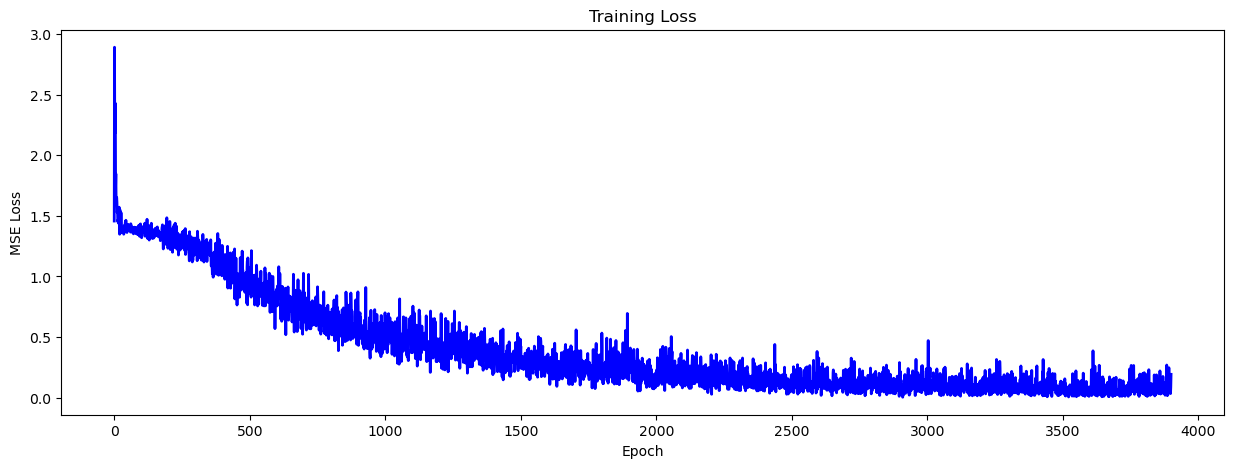

In [26]:


losses_300 = train(model=model_augmented_3, train_loader=train_loader_augmented_3, optimizer=optimizer_augmented_3, criterion=criterion_augmented_3, n_epochs=EPOCHS)
#losses_300 = train_early_stopping(model=model_augmented_3, train_loader=train_loader_augmented_3,val_loader=test_loader_augmented_3, optimizer=optimizer_augmented_3, criterion=criterion_augmented_3, n_epochs=EPOCHS)


plt.figure(figsize=(15, 5))
plt.plot(losses_300, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_augmented_3.pth'
torch.save(model_augmented_3.state_dict(), PATH)

# Resnet

In [27]:
from torchvision import models
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 4  # For 4 labels

# Load ResNet18
model_resnet = models.resnet18(pretrained=True).to(device)


# Verify the model
print(model_resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/andiv/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andiv/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# Prevent the trained weights from being modified
for name, param in model_resnet.named_parameters():
  if 'fc' not in name: # Adjust this condition to target specific layers if needed
    param.requires_grad = False


# Compute the input feature size for the first fc layer
num_ftrs_resnet = model_resnet.fc.in_features
print(num_ftrs_resnet)

# Create a new set of fc layers
classifier = [
    nn.Linear(in_features=num_ftrs_resnet, out_features=256).to(device),
    nn.ReLU(inplace=True).to(device),
    nn.Dropout(p=0.3, inplace=False).to(device),
    nn.Linear(in_features=256, out_features=4, bias=True).to(device)
]

model_resnet.fc = nn.Sequential(*classifier).to(device) # Replace the model classifier

512


In [29]:
#Hyperparameters
LEARNING_RATE_RESNET = 0.001
EPOCHS_RESNET = 20
WEIGHT_DECAY_RESNET = 1e-4  # Add weight decay regularization

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE_RESNET, weight_decay=WEIGHT_DECAY)

In [30]:
def train_resnet(model_resnet, train_loader, optimizer_resnet, criterion, n_epochs):
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
                    
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()

            # zero the parameter gradients
            optimizer_resnet.zero_grad()

            # forward + backward + optimize
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet.step()

            losses.append(loss.item())
            # print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")
    return losses 

In [31]:
# Check the accuracy of the finetuned network on the test set
def test_resnet(model_resnet, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images with ResNet and a slightly modified classifier: %d %%' % (
        100 * correct / total))

Epoch 1, loss: 0.9061510721842448
Epoch 2, loss: 0.6644956509272257
Epoch 3, loss: 0.5507990959617827
Epoch 4, loss: 0.48762589196364087
Epoch 5, loss: 0.4287952995962567
Epoch 6, loss: 0.3874501496553421
Epoch 7, loss: 0.3245758609639274
Epoch 8, loss: 0.3006994268960423
Epoch 9, loss: 0.2713793079058329
Epoch 10, loss: 0.25112184277839134
Epoch 11, loss: 0.22356430002384717
Epoch 12, loss: 0.19429949977331692
Epoch 13, loss: 0.17950698112448057
Epoch 14, loss: 0.1738834594686826
Epoch 15, loss: 0.15108265396621492
Epoch 16, loss: 0.14238617432614167
Epoch 17, loss: 0.13083557908733687
Epoch 18, loss: 0.12930071983072494
Epoch 19, loss: 0.12655582966076004
Epoch 20, loss: 0.12087450776663092


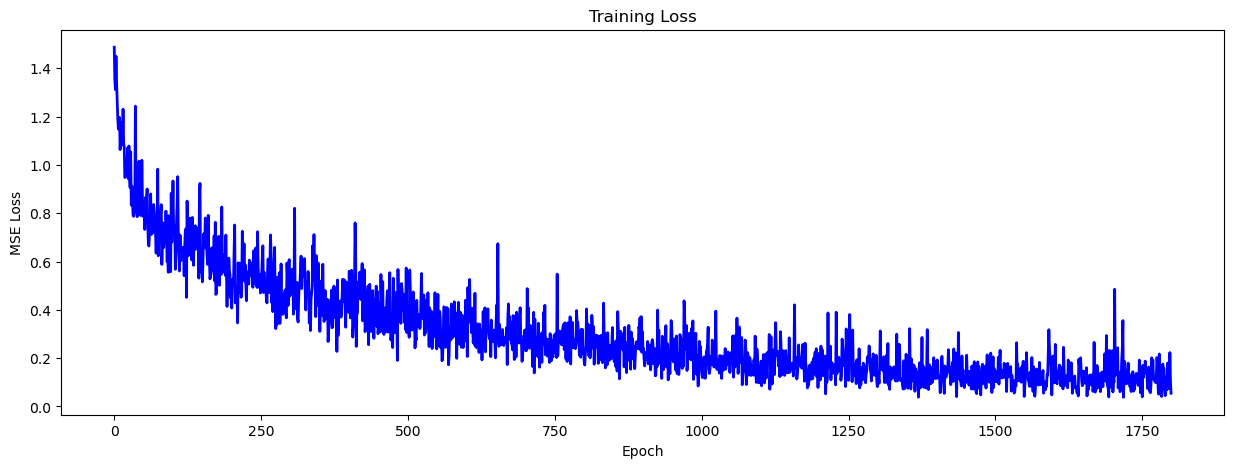

In [32]:
losses_resnet = train_resnet(model_resnet, train_loader_augmented_2, optimizer_resnet, criterion_resnet, n_epochs=EPOCHS_RESNET)


plt.figure(figsize=(15, 5))
plt.plot(losses_resnet, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './resnet.pth'
torch.save(model_resnet.state_dict(), PATH)

In [33]:
# load the model 
model_resnet.load_state_dict(torch.load('resnet.pth')) 

# Test the ResNet model
test_resnet(model_resnet, test_loader_augmented_3)

/tmp/ipykernel_83236/2180217961.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load('resnet.pth'))


Accuracy of the network on test images with ResNet and a slightly modified classifier: 88 %


# Evaluation

In [34]:
def test_accuracy(model, test_loader, device='cpu'):
    """
    Calculate and return the accuracy of the model on the test set.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    """
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy


In [35]:
# Calculate the overall accuracy
print("Model original")
overall_accuracy_original = test_accuracy(model_original, test_loader_original, device=device)

print("\nModel 100")
overall_accuracy_100 = test_accuracy(model_augmented_1, test_loader_augmented_1, device=device)

print("\nModel 200")
overall_accuracy_200 = test_accuracy(model_augmented_2, test_loader_augmented_2, device=device)

print("\nModel 300")
overall_accuracy_300 = test_accuracy(model_augmented_3, test_loader_augmented_3, device=device)

print("\nModel ResNet")
overall_accuracy_resnet = test_accuracy(model_resnet, test_loader_augmented_1, device=device)


Model original
Accuracy of the network on the test images: 83.75 %

Model 100
Accuracy of the network on the test images: 89.62 %

Model 200
Accuracy of the network on the test images: 95.28 %

Model 300
Accuracy of the network on the test images: 93.56 %

Model ResNet
Accuracy of the network on the test images: 90.88 %


In [36]:
def accuracy_classes(model, test_loader, classes, device='cpu'):
    """
    Calculate and print the accuracy for each class.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - class_accuracies: A dictionary with class names as keys and accuracy percentages as values
    """
    # Switch the model to evaluation mode
    model.eval()

    # Initialize variables for correct and total counts per class
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Compute and print accuracy for each class
    class_accuracies = {}
    for i in range(len(classes)):
        if class_total[i] > 0:  # Check to avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
            class_accuracies[classes[i]] = accuracy
        else:
            print(f'Accuracy of {classes[i]} : No samples available')
            class_accuracies[classes[i]] = None

    return class_accuracies


In [37]:
# Call the accuracy function
print("Model original")
class_accuracies = accuracy_classes(model_original, test_loader_original, classes, device=device)

print("\nModel 100")
class_accuracies_100 = accuracy_classes(model_augmented_1, test_loader_augmented_1, classes, device=device)

print("\nModel 200")
class_accuracies_200 = accuracy_classes(model_augmented_2, test_loader_augmented_2, classes, device=device)

print("\nModel 300")
class_accuracies_300 = accuracy_classes(model_augmented_3, test_loader_augmented_3, classes, device=device)

print("\nModel Resnet and Augmentation")
class_accuracies_resnet = accuracy_classes(model_resnet, test_loader_augmented_1, classes, device=device)


Model original
Accuracy of scissor : 92.31 %
Accuracy of rock : 87.18 %
Accuracy of paper : 82.86 %
Accuracy of nogesture : 74.47 %

Model 100
Accuracy of scissor : 90.96 %
Accuracy of rock : 93.16 %
Accuracy of paper : 87.56 %
Accuracy of nogesture : 87.32 %

Model 200
Accuracy of scissor : 96.42 %
Accuracy of rock : 96.36 %
Accuracy of paper : 95.10 %
Accuracy of nogesture : 93.20 %

Model 300
Accuracy of scissor : 93.30 %
Accuracy of rock : 97.51 %
Accuracy of paper : 90.86 %
Accuracy of nogesture : 92.91 %

Model Resnet and Augmentation
Accuracy of scissor : 87.77 %
Accuracy of rock : 96.32 %
Accuracy of paper : 88.52 %
Accuracy of nogesture : 91.08 %


In [38]:
import torch

#Total summary of the model

# Function to calculate precision
def calculate_precision(y_true, y_pred, class_label):
    """
    Calculate precision for a specific class.

    Parameters:
    - y_true: List or array of true labels
    - y_pred: List or array of predicted labels
    - class_label: The specific class for which precision is calculated

    Returns:
    - Precision (float)
    """
    tp = sum((y_pred == class_label) & (y_true == class_label))
    fp = sum((y_pred == class_label) & (y_true != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

# Function to calculate recall
def calculate_recall(y_true, y_pred, class_label):
    """
    Calculate recall for a specific class.

    Parameters:
    - y_true: List or array of true labels
    - y_pred: List or array of predicted labels
    - class_label: The specific class for which recall is calculated

    Returns:
    - Recall (float)
    """
    tp = sum((y_pred == class_label) & (y_true == class_label))
    fn = sum((y_pred != class_label) & (y_true == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

# Function to calculate F1 score
def calculate_f1(precision, recall):
    """
    Calculate F1 score using precision and recall.

    Parameters:
    - precision: Precision value
    - recall: Recall value

    Returns:
    - F1 score (float)
    """
    return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

# Summary function to compute all metrics
def compute_metrics_without_library(model, test_loader, classes, device='cpu'):
    """
    Compute precision, recall, and F1 score without using libraries.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: Device to use for computation ('cpu' or 'cuda')

    Returns:
    - None (prints the metrics summary)
    """
    model.eval()
    y_true = []
    y_pred = []

    # Accumulate predictions and labels
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # Compute metrics for each class
    print("Classification Report:")
    print("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))
    for i, class_label in enumerate(classes):
        precision = calculate_precision(y_true, y_pred, class_label=i)
        recall = calculate_recall(y_true, y_pred, class_label=i)
        f1 = calculate_f1(precision, recall)
        print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f}".format(class_label, precision, recall, f1))

    # Calculate overall accuracy
    accuracy = torch.sum(y_true == y_pred).item() / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.2f}")



In [39]:
# Example usage
print("Model original")
compute_metrics_without_library(model_original, test_loader_original, classes=classes, device='cpu')

print("\nModel 100")
compute_metrics_without_library(model_augmented_1, test_loader_augmented_1, classes=classes, device='cpu')

print("\nModel 200")
compute_metrics_without_library(model_augmented_2, test_loader_augmented_2, classes=classes, device='cpu')

print("\nModel 300")
compute_metrics_without_library(model_augmented_3, test_loader_augmented_3, classes=classes, device='cpu')

print("\nModel ResNet")
compute_metrics_without_library(model_resnet, test_loader_augmented_1, classes=classes, device='cpu')

Model original
Classification Report:
Class           Precision  Recall     F1-Score  
scissor         0.86       0.92       0.89      
rock            0.74       0.87       0.80      
paper           0.81       0.83       0.82      
nogesture       0.97       0.74       0.84      

Overall Accuracy: 0.84

Model 100
Classification Report:
Class           Precision  Recall     F1-Score  
scissor         0.88       0.91       0.89      
rock            0.92       0.93       0.93      
paper           0.91       0.88       0.89      
nogesture       0.88       0.87       0.88      

Overall Accuracy: 0.90

Model 200
Classification Report:
Class           Precision  Recall     F1-Score  
scissor         0.94       0.96       0.95      
rock            0.97       0.96       0.97      
paper           0.98       0.95       0.97      
nogesture       0.92       0.93       0.93      

Overall Accuracy: 0.95

Model 300
Classification Report:
Class           Precision  Recall     F1-Score  
scis

In [40]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, test_loader, label_map, device='cpu',average='weighted'):
    """
    Evaluate the model on a test set and visualize the results.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - label_map: Dictionary mapping class indices to class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    - conf_matrix: Confusion matrix of the test set predictions
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = 100 * correct / total


    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print accuracy
    print(f"Accuracy of the network on the test set: {accuracy:.2f}%")

    # Visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", 
                xticklabels=label_map.values(), 
                yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix


Model original

Model 100
Accuracy of the network on the test set: 89.62%


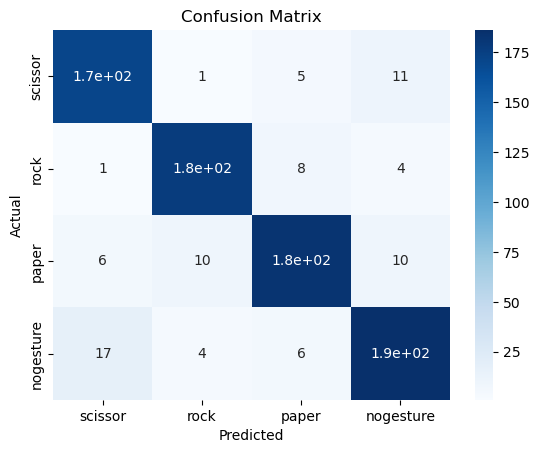


Model 200
Accuracy of the network on the test set: 95.28%


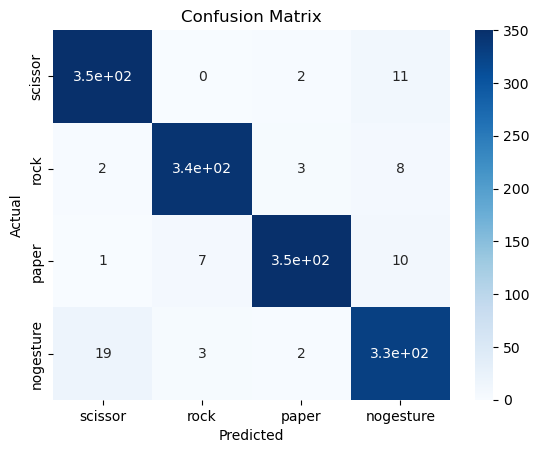


Model 300
Accuracy of the network on the test set: 93.56%


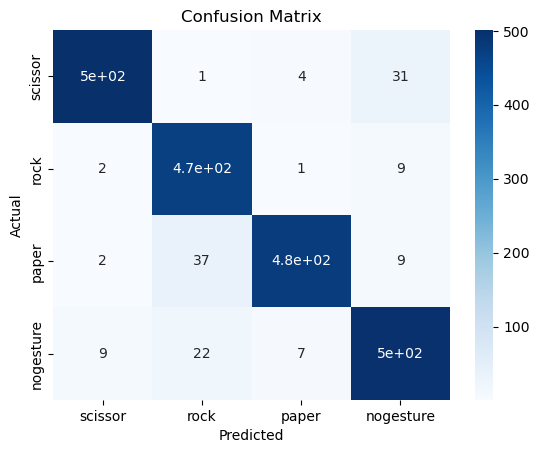


Model Resnet
Accuracy of the network on the test set: 90.88%


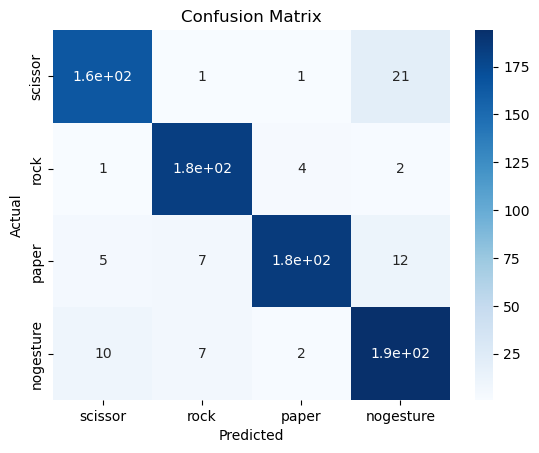

In [ ]:
# Define the label map
label_map = {i: class_name for i, class_name in enumerate(classes)}

# Evaluate the model
print("Model original")
overall_accuracy, confusion_mat = evaluate_model(model_original, test_loader_original, label_map, device=device,average='weighted')

print("\nModel 100")
overall_accuracy_100, confusion_mat_100 = evaluate_model(model_augmented_1, test_loader_augmented_1, label_map, device=device,average='weighted')

print("\nModel 200")
overall_accuracy_200, confusion_mat_200 = evaluate_model(model_augmented_2, test_loader_augmented_2, label_map, device=device,average='weighted')

print("\nModel 300")
overall_accuracy_300, confusion_mat_300 = evaluate_model(model_augmented_3, test_loader_augmented_3, label_map, device=device,average='weighted')

print("\nModel Resnet")
overall_accuracy_resnet, confusion_mat_resnet = evaluate_model(model_resnet, test_loader_augmented_1, label_map, device=device,average='weighted')


# Demo

In [5]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

""" DEMO 1:
    Press 'c' to capture an image from the webcam and predict the label (print to console).
    Press 'q' to quit the application.
 """

device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 4  # For 4 labels

count = 0

model = Net()

model.load_state_dict(torch.load('model_original.pth'))

model.eval()

cap = cv2.VideoCapture(0)

# Define the class mapping
class_map = {0: 'scissor', 1: 'rock', 2: 'paper', 3: 'nogesture'}

# Define the transformation including normalization (adjust mean and std based on your training data)
transform = transforms.Compose([
    transforms.ToTensor(),
])

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to capture frame")
        break

    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame
    cv2.imshow("Live Video", frame)

    if cv2.waitKey(1) & 0xFF == ord('c'):
        count += 1
        img = cv2.resize(frame_rgb, (128, 128))

        # Transform the image for the model
        img = transform(img)

        # Save image to disk 
        img_np = img.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
        img_np = (img_np * 255).astype(np.uint8)  # Rescale to 0-255 and convert to uint8
        cv2.imwrite("output_image.jpg", cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))  # Save as BGR

        img = img.unsqueeze(0)  # Add batch dimension

        print(f"Type={img.dtype}, Min={img.min().item()}, Max={img.max().item()}, Shape={img.shape}")

        # Predict the label
        output = model(img)
        _, predicted_label = torch.max(output, 1)

        # Extract the scalar value and use it to look up the class name
        predicted_label = predicted_label.item()  # Convert tensor to integer
        print(f"Predicted label: {class_map[predicted_label]}")

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


/tmp/ipykernel_25755/4067218387.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_original.pth'))


Type=torch.float32, Min=0.003921568859368563, Max=1.0, Shape=torch.Size([1, 3, 128, 128])
Predicted label: nogesture


In [4]:
import cv2
import numpy as np
import math
import torch
import torchvision.transforms as transforms
from PIL import Image

""" DEMO 2:
    Realtime gesture recognition our trained model 3.
    Press 'Esc' to quit the application.
"""

# Load your PyTorch model
class_map = {0: 'scissor', 1: 'rock', 2: 'paper', 3: 'nogesture'}
model_augmented_3 = Net()
model_augmented_3.load_state_dict(torch.load('model_augmented_3.pth'))

# Define transformations for the model
transform = transforms.Compose([
    transforms.ToTensor()
])

cap = cv2.VideoCapture(0)

while True:
    try:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)

        # Define a larger ROI
        roi = frame[100:400, 100:400]  # 300x300 square
        cv2.rectangle(frame, (100, 100), (400, 400), (0, 255, 0), 2)

        # Convert ROI to HSV for mask creation
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

        # Define the skin color range
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)

        # Mask the skin color region
        mask = cv2.inRange(hsv, lower_skin, upper_skin)

        # Refine the mask
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=4)
        mask = cv2.GaussianBlur(mask, (5, 5), 100)

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Get the largest contour (hand)
            cnt = max(contours, key=cv2.contourArea)
            epsilon = 0.0005 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            # Draw convex hull
            hull = cv2.convexHull(cnt)
            cv2.drawContours(roi, [hull], -1, (0, 255, 0), 2)

            # Prepare ROI for prediction
            roi_resized = cv2.resize(roi, (128, 128))  # Match model input size
            img = transform(roi_resized)
            img = img.unsqueeze(0)  # Add batch dimension
            img = img.float()

            # Predict using the model
            output = model_augmented_3(img)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted_label = torch.max(probabilities, 1)
            confidence = confidence.item()
            predicted_label = predicted_label.item()

            # Display the prediction and confidence
            label = class_map[predicted_label]
            text = f"{label} ({confidence * 100:.2f}%)"
            cv2.putText(frame, text, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        # Show the windows
        cv2.imshow('Mask', mask)
        cv2.imshow('Frame', frame)

    except Exception as e:
        print(f"Error: {e}")

    # Break on pressing 'Esc'
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()


/tmp/ipykernel_25755/3131639516.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_augmented_3.load_state_dict(torch.load('model_augmented_3.pth'))
